# Machine Learning Model for Stress Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Preprocessing and Feature Extraction

In [2]:
def preprocess_and_extract_features(file_path, window_size=250, overlap=0.5):
    """
    Preprocess the time series data and extract features for classification.
    Features are extracted per fixed-length window with overlap.
    """
    # Load the data
    data = pd.read_csv(file_path)
    
    # Sanity check to make sure data is there
    if not {'ppg_raw', 'gsr_raw'}.issubset(data.columns):
        raise ValueError("Data must contain 'ppg_raw' and 'gsr_raw' columns.")
    
    # Initialize feature list
    features_list = []
    step_size = int(window_size * (1 - overlap))
    
    # Sliding window approach
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size]
        
        # Time-domain features
        ppg_mean = window['ppg_raw'].mean()
        ppg_std = window['ppg_raw'].std()
        ppg_max = window['ppg_raw'].max()
        ppg_min = window['ppg_raw'].min()
        ppg_range = ppg_max - ppg_min
        ppg_rms = np.sqrt(np.mean(window['ppg_raw'] ** 2))
        ppg_peaks = len((window['ppg_raw'].diff() > 0).astype(int).diff().eq(-1).index)
        
        gsr_mean = window['gsr_raw'].mean()
        gsr_std = window['gsr_raw'].std()
        gsr_max = window['gsr_raw'].max()
        gsr_min = window['gsr_raw'].min()
        gsr_range = gsr_max - gsr_min
        gsr_rms = np.sqrt(np.mean(window['gsr_raw'] ** 2))
        gsr_peaks = len((window['gsr_raw'].diff() > 0).astype(int).diff().eq(-1).index)
        
        # GSR-specific features
        gsr_amplitude = gsr_max - gsr_mean
        gsr_response_count = len(window['gsr_raw'][window['gsr_raw'].diff() > 0])
        
        # Combine features into a dictionary
        features = {
            'ppg_mean': ppg_mean,
            'ppg_std': ppg_std,
            'ppg_max': ppg_max,
            'ppg_min': ppg_min,
            'ppg_range': ppg_range,
            'ppg_rms': ppg_rms,
            'ppg_peaks': ppg_peaks,
            'gsr_mean': gsr_mean,
            'gsr_std': gsr_std,
            'gsr_max': gsr_max,
            'gsr_min': gsr_min,
            'gsr_range': gsr_range,
            'gsr_rms': gsr_rms,
            'gsr_peaks': gsr_peaks,
            'gsr_amplitude': gsr_amplitude,
            'gsr_response_count': gsr_response_count
        }
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

## Load and Preprocess Data

In [3]:
#testing filepath
import os
print(os.getcwd())

/Users/evani/Downloads/research - HCI/responsive_mouse


In [ ]:
# File paths for the datasets (these are specfic to my computer)
# Add here as more files get added
file_paths = [
    "./arduino_data/data/4_resting_trial1.csv",
    "./arduino_data/data/4_resting_trial2.csv",
    "./arduino_data/data/4_stressed_trial1.csv",
    "./arduino_data/data/4_stressed_trial2.csv"
]

# Combine features and labels
features = []
labels = []
for file_path in file_paths:
    label = "stressed" if "stressed" in file_path else "not_stressed"
    # Make window size smaller for more features
    data_features = preprocess_and_extract_features(file_path)
    features.append(data_features)
    labels.extend([label] * len(data_features))

X = pd.concat(features, ignore_index=True)
y = pd.Series(labels)

In [5]:
# Display headers and first 5 rows of X
print("X DataFrame Headers:", X.columns.tolist())
print("\nFirst 5 Rows of X:")
print(X.head())

# Display first 5 rows of y
print("\nFirst 5 Rows of y:")
print(y.head())
# Display the size of the DataFrames
print(f'Size of X: {X.shape}')
print(f'Size of y: {y.shape}')

X DataFrame Headers: ['ppg_mean', 'ppg_std', 'ppg_max', 'ppg_min', 'ppg_range', 'ppg_rms', 'ppg_peaks', 'gsr_mean', 'gsr_std', 'gsr_max', 'gsr_min', 'gsr_range', 'gsr_rms', 'gsr_peaks', 'gsr_amplitude', 'gsr_response_count']

First 5 Rows of X:
   ppg_mean     ppg_std  ppg_max  ppg_min  ppg_range      ppg_rms  ppg_peaks  \
0  1273.220  784.757044     4095        0       4095  1494.814173        250   
1  1258.516  781.028954     4095        0       4095  1480.347501        250   
2  1292.420   19.080984     1333     1241         92  1292.560283        250   
3  1300.088   16.985000     1352     1248        104  1300.198502        250   
4  1302.864   15.157192     1352     1262         90  1302.951812        250   

   gsr_mean    gsr_std  gsr_max  gsr_min  gsr_range      gsr_rms  gsr_peaks  \
0  1931.476  35.632121     2001     1851        150  1931.803331        250   
1  1921.768  11.571767     1945     1895         50  1921.802700        250   
2  1932.176  10.414744     1955     1

## Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Model

In [7]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate the Model

In [8]:
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Evaluate the model using k-fold cross-validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score

# Perform k-fold cross-validation
k = 5  
cv_accuracy = cross_val_score(model, X, y, cv=k, scoring='accuracy')
y_pred = cross_val_predict(model, X, y, cv=k)

print(f'Cross-Validation Accuracy (mean): {cv_accuracy.mean():.2f}')
print(f'Cross-Validation Accuracy (std): {cv_accuracy.std():.2f}')
print("Classification Report:", classification_report(y, y_pred))

Cross-Validation Accuracy (mean): 0.86
Cross-Validation Accuracy (std): 0.15
Classification Report:               precision    recall  f1-score   support

not_stressed       0.78      0.89      0.83        35
    stressed       0.93      0.85      0.88        59

    accuracy                           0.86        94
   macro avg       0.85      0.87      0.86        94
weighted avg       0.87      0.86      0.86        94



## Save the Model (Optional)

In [10]:
import joblib
joblib.dump(model, "stress_classifier.pkl")

# import os
# import joblib

# # Define the directory and file path
# save_dir = "models"
# save_path = os.path.join(save_dir, "stress_classifier.pkl")

# # Create the directory if it doesn't exist
# os.makedirs(save_dir, exist_ok=True)

# # Save the trained model
# joblib.dump(model, save_path)

# print(f"Model saved to {save_path}")


['stress_classifier.pkl']

In [ ]:
# # Visualize the classification report results in a heatmap
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report
# import pandas as pd

# Classification report as a dictionary
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# # Plot the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
# plt.title('Classification Report Heatmap')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

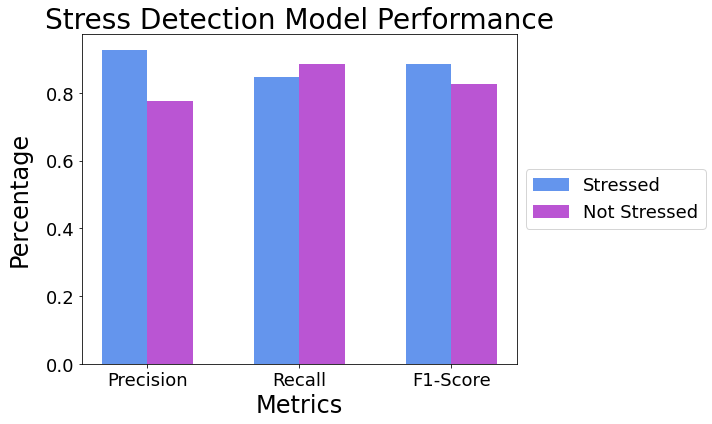

In [ ]:
# Double bar graph for precision, recall, and F1-score
import matplotlib.pyplot as plt
import numpy as np

# Save font sizes
TITLE_FS  = 28
LABELS_FS  = 24
LEGEND_FS = 18
TICK_FS   = 18

# Metrics for two classes
stressed_metrics = report_df.loc['stressed', ['precision', 'recall', 'f1-score']].values
not_stressed_metrics = report_df.loc['not_stressed', ['precision', 'recall', 'f1-score']].values
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))

# Plot bars
width = 0.3 
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, stressed_metrics, width, label='Stressed', color='cornflowerblue')
bar2 = ax.bar(x + width/2, not_stressed_metrics, width, label='Not Stressed', color='mediumorchid')

# Add labels, title, legend
ax.set_xlabel('Metrics', fontsize=LABELS_FS)
ax.set_ylabel('Percentage', fontsize=LABELS_FS, labelpad=15)
ax.set_title('Stress Detection Model Performance', fontsize=TITLE_FS)
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Resize the tick‐labels (the numbers / text on the axes)
ax.tick_params(axis='x', labelsize=TICK_FS)  # X-axis numbers/text size
ax.tick_params(axis='y', labelsize=TICK_FS)  # Y-axis numbers/text size

# Add value annotations on bars
# for bar in bar1 + bar2:
#     height = bar.get_height()
#     ax.annotate(f'{height:.2f}',
#                 xy=(bar.get_x() + bar.get_width() / 2, height),
#                 xytext=(0, 3),
#                 textcoords='offset points',
#                 ha='center', va='bottom')

# Move legend to the right side, centered vertically
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=LEGEND_FS)

# Make room on the right for the legend
plt.subplots_adjust(right=0.8)

plt.tight_layout()
plt.show()